# Model DM

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm
import arch as am

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
import src

sys.path.append('../../kungfu/')
import kungfu as kf

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

## Load data

In [6]:
df_predictors = pd.read_pickle('../data/external/df_predictors.pkl')
s_dp = df_predictors.dp.asfreq('M')
s_ret = df_predictors['Index'].pct_change().asfreq('M')

In [7]:
div_yield = s_dp.diff()[s_dp.index.year >= 1980]
returns = s_ret[s_ret.index.year >= 1980]

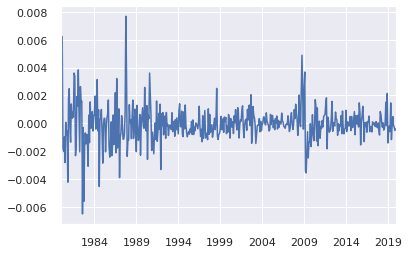

In [8]:
div_yield.plot()
plt.show()

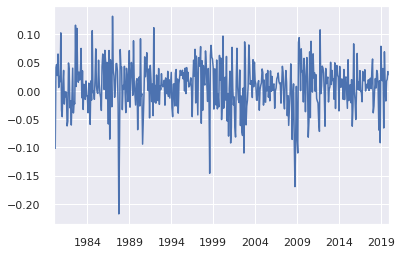

In [9]:
returns.plot()
plt.show()

## Modelling

In [10]:
series = returns

### Fit

In [27]:
from src.model import HMM

hmm = HMM(switch_var=True, k=4)
hmm = hmm.fit(series, start_params=None)

/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


../src/model.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if state == 'steady_state':
../src/model.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif state == 'latest':


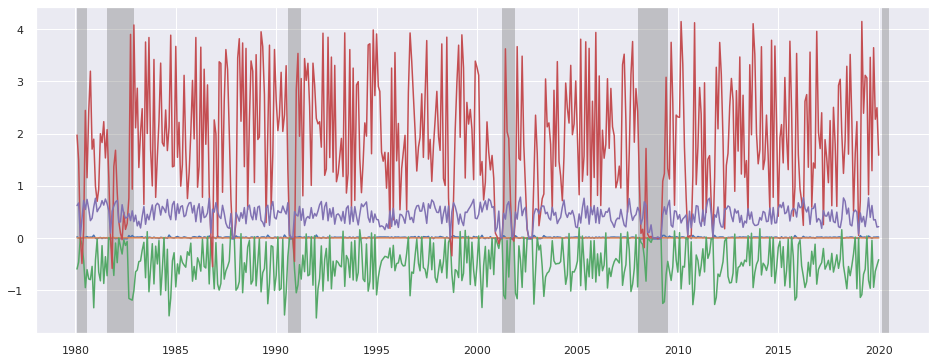

In [28]:
mom = hmm.filtered_moments()

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(mom)
kf.add_recession_bars(ax, startdate=mom.index[0])
plt.show()

<AxesSubplot:>

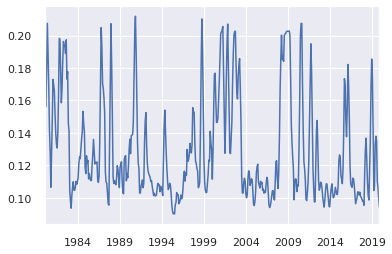

In [29]:
(mom['var']**0.5*np.sqrt(12)).rolling(3).mean().plot()

../src/model.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if state == 'steady_state':
../src/model.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif state == 'latest':


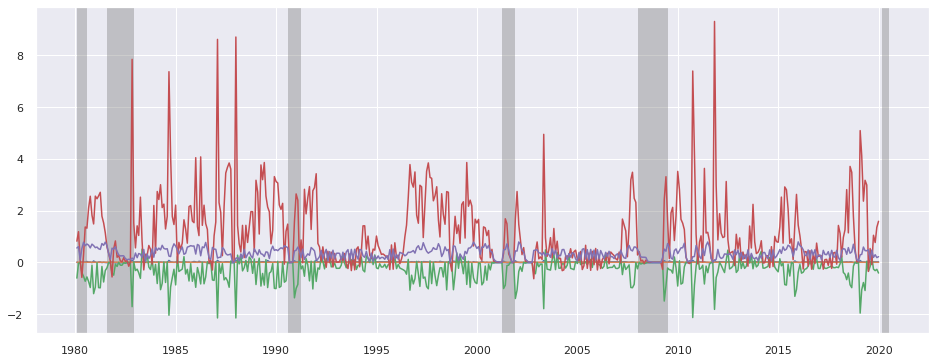

In [30]:
mom = hmm.smoothened_moments()

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(mom)
kf.add_recession_bars(ax, startdate=mom.index[0])
plt.show()

<AxesSubplot:>

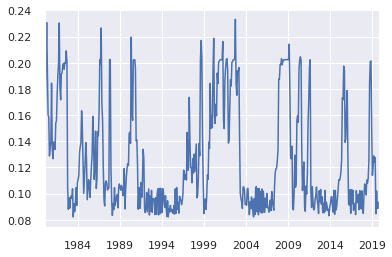

In [31]:
(mom['var']**0.5*np.sqrt(12)).plot()

<AxesSubplot:>

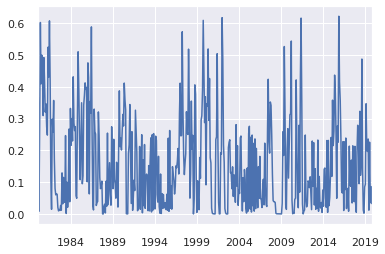

In [32]:
(mom['entropy']**2).plot()

### Plot

In [49]:
from src.plots import plot_mixture_pdf, plot_mixture_components, plot_kernel_density, plot_fitted_normal

mix = hmm.get_mixture_distribution(state='steady_state')

fig, ax = plt.subplots(1, 1, figsize=[16,6])

plot_mixture_pdf(mix, ax=ax, label='Mixture')
plot_mixture_components(mix, ax=ax)
plot_kernel_density(series, ax=ax, label='Data KDE', color='grey')
ax.axhline(0, color='k', linewidth=1)
ax.axvline(0, color='k', linewidth=1)
plot_fitted_normal(series, ax=ax, linestyle='--', color='k', label='Normal')
ax.legend()

plt.show()

AttributeError: 'MarkovRegressionResults' object has no attribute 'get_mixture_distribution'

In [34]:
mix.components

[(-0.01821192107045016, 0.022363252962660996, 0.18408634935905527),
 (0.020950714564851723, 0.023295901376933156, 0.5351213527136829),
 (0.07986389766044726, 0.02283080517284564, 0.05026956748099323),
 (-0.01701208484755535, 0.05842918131346118, 0.2305227304462687)]

In [35]:
hmm.transition_matrix_.round(2)

array([[0.02, 0.73, 0.07, 0.18],
       [0.34, 0.66, 0.  , 0.01],
       [0.  , 0.99, 0.  , 0.  ],
       [0.  , 0.  , 0.16, 0.84]])

In [50]:
%%time
fit_stats = pd.DataFrame(columns=['llf','aic','bic'])
for k in range(2,11):
    hmm = HMM(switch_var=True, k=k).fit(series)
    fit_stats = fit_stats.append(hmm.metrics_.rename(k))
fit_stats

/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:568: Conve

CPU times: user 12min 13s, sys: 43.3 s, total: 12min 56s
Wall time: 11min 29s


,llf,aic,bic
2,867.2589,-1722.5179,-1697.4752
3,875.4253,-1726.8506,-1676.7652
4,878.4724,-1716.9447,-1633.4690
5,884.1989,-1708.3977,-1583.1841
6,887.7165,-1691.4329,-1516.1339
7,884.1191,-1656.2382,-1422.5062
8,897.9796,-1651.9593,-1351.4467
9,900.9885,-1621.9770,-1246.3362
10,912.0602,-1604.1205,-1145.0040


<AxesSubplot:>

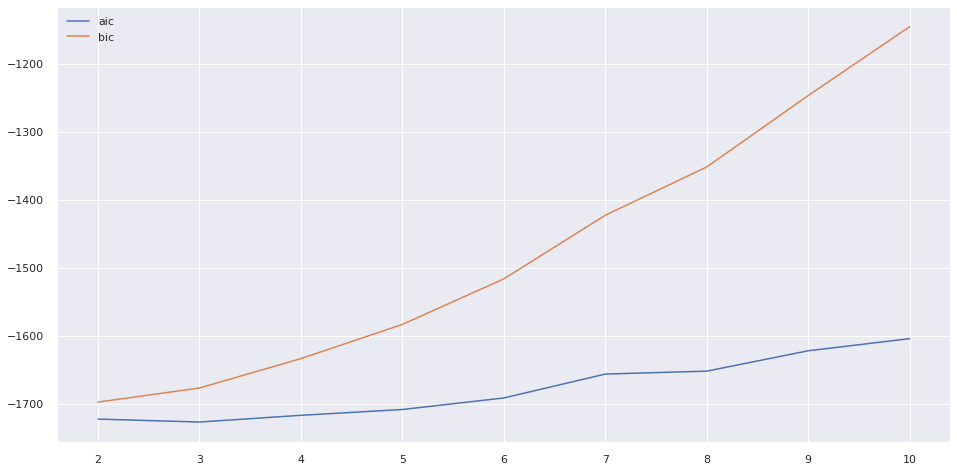

In [51]:
fit_stats[['aic','bic']].plot(figsize=[16,8])

<AxesSubplot:>

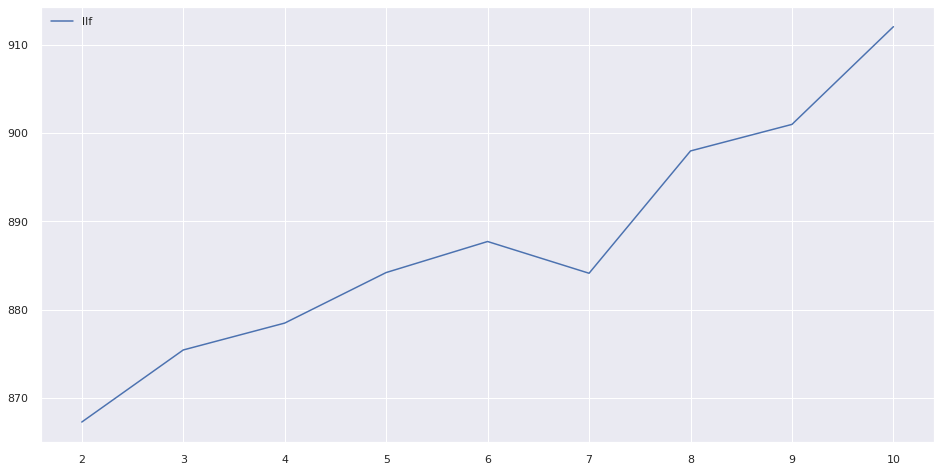

In [52]:
fit_stats[['llf']].plot(figsize=[16,8])

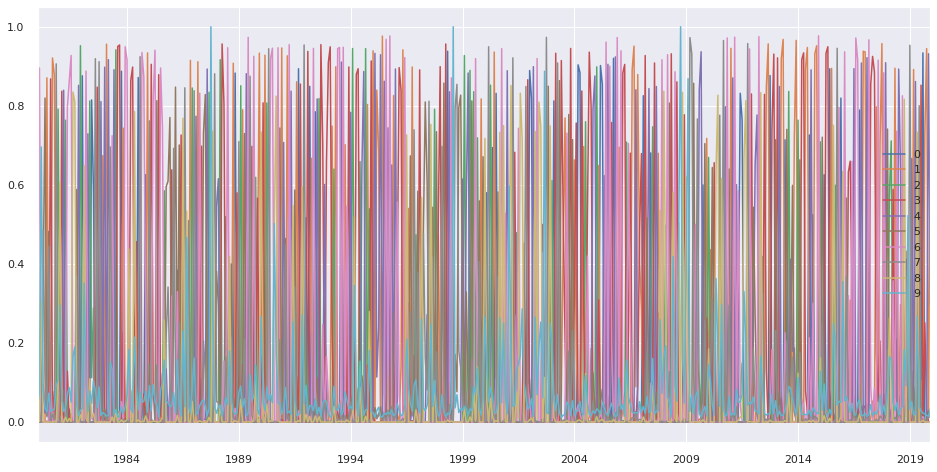

In [53]:
hmm.filt_prob_.plot(figsize=[16,8])
plt.show()

../src/model.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if state == 'steady_state':
../src/model.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif state == 'latest':


<AxesSubplot:>

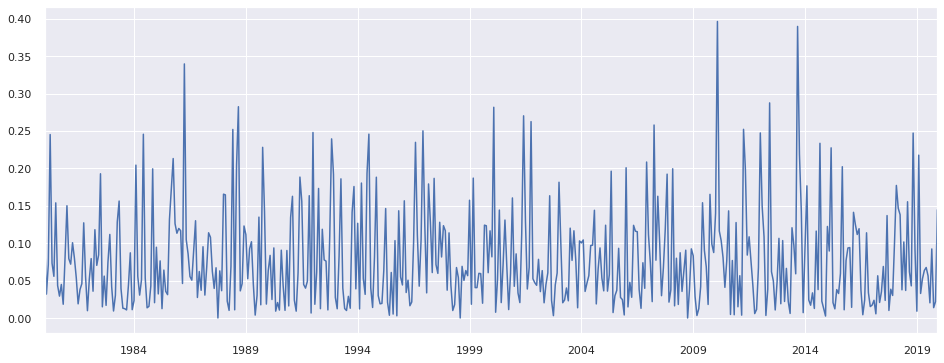

In [59]:
(hmm.filtered_moments()['entropy']**2).plot(figsize=(16,6))